# Clustering House Legislatures

In this notebook, we will reduce voting behavior from a multidimensional matrix accounting each bill, to a two-dimensional matrix representing relevant voting attributes.

We will look both at PCA and KMeans.

#### Import packages and download data

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

Download voting data.

In [2]:
votes = pd.read_csv('http://gadatascience.com/datasets/congress/congressional_votes.csv')
congress = votes[['display_name', 'id', 'party', 'state']].drop_duplicates().sort('display_name').reset_index(drop=True)
print "We have %d votes on %d bills from %d members in congress." % \
    (len(votes), votes.question.nunique(), len(congress))

We have 53863 votes on 129 bills from 438 members in congress.


In [3]:
votes.head()

,display_name,id,party,state,Vote,question
0,Amash,A000367,R,MI,1,On Passage: H R 2279 Reducing Excessive Deadli...
1,Amodei,A000369,R,NV,1,On Passage: H R 2279 Reducing Excessive Deadli...
2,Bachmann,B001256,R,MN,1,On Passage: H R 2279 Reducing Excessive Deadli...
3,Bachus,B000013,R,AL,1,On Passage: H R 2279 Reducing Excessive Deadli...
4,Barletta,B001269,R,PA,1,On Passage: H R 2279 Reducing Excessive Deadli...


In [4]:
congress.head()

,display_name,id,party,state
0,Adams,A000370,D,NC
1,Aderholt,A000055,R,AL
2,Amash,A000367,R,MI
3,Amodei,A000369,R,NV
4,Andrews,A000210,D,NJ


#### Create a representative-by-bill voting matrix

Pivot tables are commonly used to transform a dataset from long form to wide form.
This means we take data that appears in a column and make a new column per value.
For each row in the new columns, we can aggregate or fill in a value from another column.

Here, we use them to take each row of a vote and make a new column per bill, with the Yes/No vote as the value. We denote Yes by `1`, No by `-1` and No Vote by `None`.

    voting_matrix = pd.pivot_table(votes, index='display_name', columns='question', values='Vote', fill_value=None)
    
- `index` is the column to use as a 'primary key', one per record item,
- `columns` is the column to be used to create the new header, and
- `values` is the column to be used to fill the newly create columns.

Equivalenty, we could use a `groupby` statement, which creates a multilevel series, and `unstack` back to a dataframe.

    voting_matrix = votes.groupby(['display_name', 'question']).Vote.first().unstack()
    


In [5]:
voting_matrix = votes.groupby(['display_name', 'question']).Vote.first().unstack()
# same as: pd.pivot_table(votes, index='display_name', columns='question', values='Vote', fill_value=None)
voting_matrix = voting_matrix.replace(0, -1).fillna(0)

#### PCA
Pick an arbitrary number of components you'd be interested in. Since the PCs will be ordered by relevance, you'll always catch the most relevant ones. In theory, you could extract as many components as you have features (columns) in your data.

In [6]:
n_components = 4

In [7]:
model = PCA(n_components=n_components)
PCs = model.fit_transform(voting_matrix)  # principal components
congress['PC1'] = PCs[:, 0]
congress['PC2'] = PCs[:, 1]
congress.head()

,display_name,id,party,state,PC1,PC2
0,Adams,A000370,D,NC,2.483730,-1.367399
1,Aderholt,A000055,R,AL,-8.229238,0.381537
2,Amash,A000367,R,MI,-7.170478,-6.018009
3,Amodei,A000369,R,NV,-7.404195,1.136015
4,Andrews,A000210,D,NJ,2.591377,-1.905903


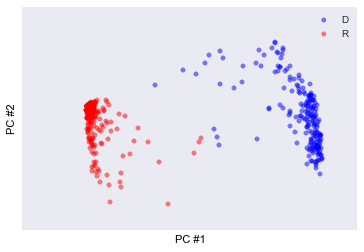

In [8]:
colors = {'D': 'b', 'R': 'r'}
for party in congress.party.unique():
    representatives = congress[congress.party == party]
    plt.scatter(representatives.PC1, representatives.PC2, color=colors[party], alpha=.5, label=party)
f = plt.legend(), plt.xticks([]), plt.yticks([]), plt.xlabel("PC #1"), plt.ylabel("PC #2")

Clearly, the first principal component represents a member's political affiliation.

You might wonder if you could extract more patterns from the data, like geographical behavior that goes across parties.

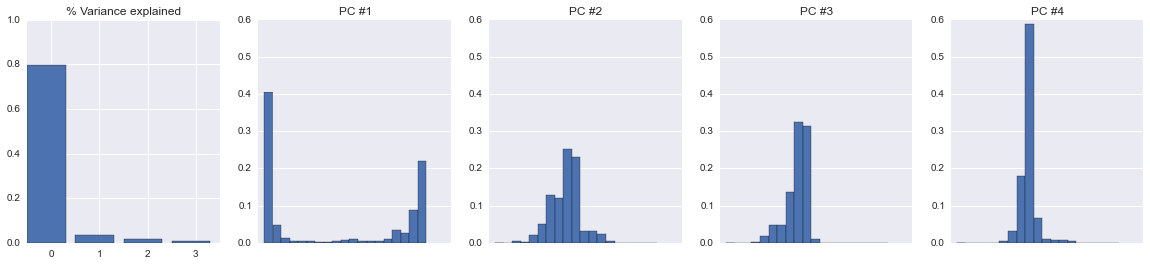

In [9]:
fig, axes = plt.subplots(1, n_components + 1, figsize=(20, 4))
ax = axes[0]
ax.bar(np.arange(n_components)-.5, model.explained_variance_ratio_)
ax.set_ylim(0, 1), ax.set_xticks(range(n_components)), ax.set_title("% Variance explained")
bins = np.linspace(PCs.min(), PCs.max(), 20)
for no, ax in enumerate(axes[1:]):
    f = ax.hist(PCs[:, no], bins=bins, normed=True)
    ax.set_title("PC #%d" % (no + 1)), ax.set_ylim(0, .6), ax.set_xticks([])

It's reasonable to believe that only the first principal component matters, since
- it explains 80% of all variance, whereas the next in line only accounts for about 3%,
- the Gaussian-like distribution of the other PCs suggests their variance is just noise.

#### KMeans

What will we get if we'd apply k-means instead of PCA?

Note that our data has already been normalized (with only -1, 0, 1 in each column).

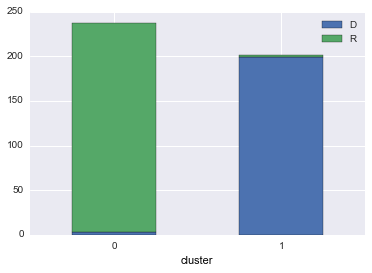

In [10]:
model = KMeans(n_clusters=2)
congress['cluster'] = model.fit_predict(voting_matrix)
f = congress.groupby('cluster').party.value_counts().unstack().plot(kind='bar', rot=0, stacked=True)

Voting behavior is clearly dependend on political affiliation.

Wheras the previous analysis of PCs #2 and up was discouraging, let's see if it would make sense to find more clusters.

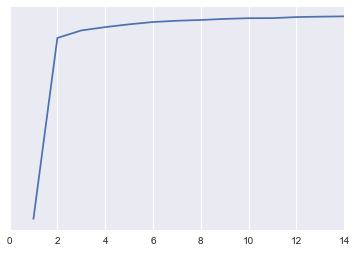

In [12]:
max_clusters = 15
scores = []
for k in xrange(1, max_clusters):
    model = KMeans(n_clusters=k)
    scores.append(model.fit(voting_matrix).score(voting_matrix))
f = plt.plot(range(1, max_clusters), scores), plt.yticks([])

Nope. Further clustering seems not valuable.